In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from PIL import Image
import glob
import os 

In [14]:
paths = []
labels = []
for flower in os.listdir('/kaggle/input/flowers-recognition/flowers'):
    path_data = os.listdir(os.path.join("/kaggle/input/flowers-recognition/flowers", flower))
    cur_path = os.path.join("/kaggle/input/flowers-recognition/flowers", flower)
    paths.extend([os.path.join(cur_path, img) for img in path_data])
    labels.extend([flower]*len(path_data))

<Axes: >

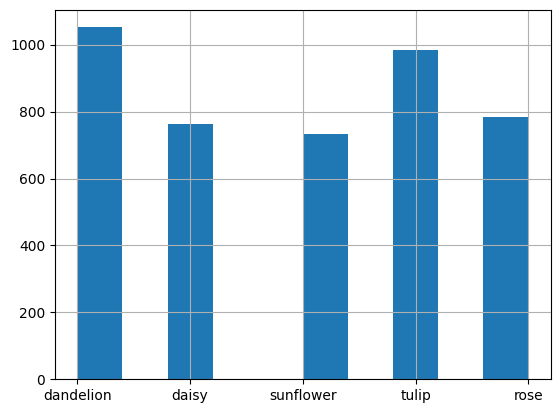

In [25]:
import pandas as pd
data = pd.DataFrame({"path":paths, "label":labels})
data.label.hist()

In [27]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


# Replace non-numeric values with NaN
data.iloc[:, :-1] = data.iloc[:, :-1].apply(pd.to_numeric, errors='coerce')

# Fill missing values (if any) with 0 (or other appropriate value)
data.fillna(0, inplace=True)

# Convert features to float
X = data.iloc[:, :-1].astype(float).values
y = data.iloc[:, -1].values

# Normalize pixel values
X = X / 255.0


# One-hot encode labels
lb = LabelBinarizer()
y = lb.fit_transform(y)

# Split into train, validation, and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

/tmp/ipykernel_24/3004839911.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.fillna(0, inplace=True)


In [30]:
# MLP structure
input_dim = X_train.shape[1]
hidden_dim = 64
output_dim = y_train.shape[1]

# Random initialization
np.random.seed(42)
weights = {
    "W1": np.random.randn(input_dim, hidden_dim) * 0.01,
    "W2": np.random.randn(hidden_dim, output_dim) * 0.01,
}
biases = {
    "b1": np.zeros((1, hidden_dim)),
    "b2": np.zeros((1, output_dim)),
}

In [32]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def forward_pass(X, weights, biases):
    # Hidden layer
    Z1 = np.dot(X, weights["W1"]) + biases["b1"]
    A1 = sigmoid(Z1)
    # Output layer
    Z2 = np.dot(A1, weights["W2"]) + biases["b2"]
    A2 = softmax(Z2)
    return A1, A2

In [33]:
def backward_pass(X, y, A1, A2, weights):
    m = X.shape[0]  # Number of samples

    # Compute gradients
    dZ2 = A2 - y
    dW2 = np.dot(A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    dA1 = np.dot(dZ2, weights["W2"].T)
    dZ1 = dA1 * A1 * (1 - A1)
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    return {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

In [35]:
def update_weights(weights, biases, gradients, learning_rate=0.01):
    weights["W1"] -= learning_rate * gradients["dW1"]
    biases["b1"] -= learning_rate * gradients["db1"]
    weights["W2"] -= learning_rate * gradients["dW2"]
    biases["b2"] -= learning_rate * gradients["db2"]

In [36]:
epochs = 10
learning_rate = 0.01

for epoch in range(epochs):
    # Forward pass
    A1, A2 = forward_pass(X_train, weights, biases)
    
    # Compute loss (categorical cross-entropy)
    loss = -np.mean(np.sum(y_train * np.log(A2 + 1e-8), axis=1))
    
    # Backward pass
    gradients = backward_pass(X_train, y_train, A1, A2, weights)
    
    # Update weights
    update_weights(weights, biases, gradients, learning_rate)
    
    # Validation accuracy
    _, A2_val = forward_pass(X_val, weights, biases)
    y_pred = np.argmax(A2_val, axis=1)
    y_true = np.argmax(y_val, axis=1)
    val_accuracy = accuracy_score(y_true, y_pred)
    
    print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


Epoch 1/10 - Loss: 1.6106, Val Accuracy: 0.1806
Epoch 2/10 - Loss: 1.6098, Val Accuracy: 0.2072
Epoch 3/10 - Loss: 1.6090, Val Accuracy: 0.2072
Epoch 4/10 - Loss: 1.6083, Val Accuracy: 0.2072
Epoch 5/10 - Loss: 1.6076, Val Accuracy: 0.2072
Epoch 6/10 - Loss: 1.6070, Val Accuracy: 0.2072
Epoch 7/10 - Loss: 1.6064, Val Accuracy: 0.2072
Epoch 8/10 - Loss: 1.6058, Val Accuracy: 0.2072
Epoch 9/10 - Loss: 1.6053, Val Accuracy: 0.2072
Epoch 10/10 - Loss: 1.6048, Val Accuracy: 0.2072


In [37]:
# Test predictions
_, A2_test = forward_pass(X_val, weights, biases)
y_pred = np.argmax(A2_test, axis=1)
y_true = np.argmax(y_val, axis=1)

# Classification report
print("Classification Report:\n", classification_report(y_true, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       161
           1       0.00      0.00      0.00       224
           2       0.00      0.00      0.00       156
           3       0.00      0.00      0.00       144
           4       0.21      1.00      0.34       179

    accuracy                           0.21       864
   macro avg       0.04      0.20      0.07       864
weighted avg       0.04      0.21      0.07       864



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


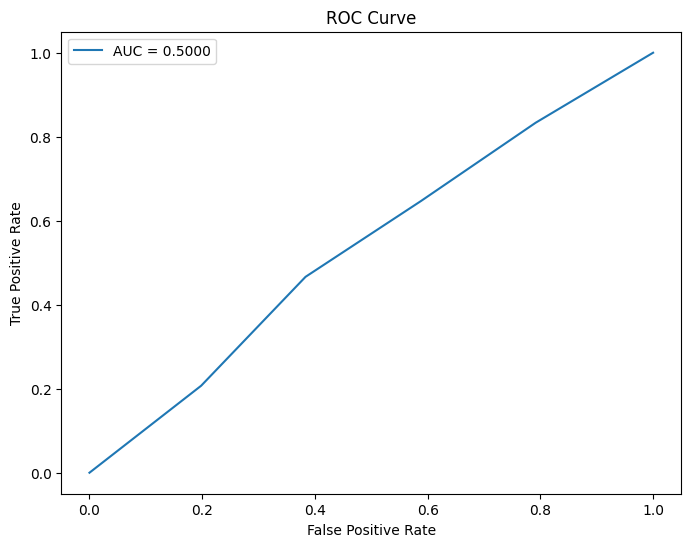

In [38]:
# Compute AUC and ROC for each class
y_scores = A2_test
fpr, tpr, _ = roc_curve(y_val.ravel(), y_scores.ravel())
auc_score = roc_auc_score(y_val, y_scores, multi_class="ovr")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
